In [10]:
import os
import sys
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
# plt.style.use('seaborn-paper')
import seaborn as sns
matplotlib.rc('text', usetex=True)

import time, datetime
import itertools
from joblib import Parallel, delayed
import pickle

In [2]:
data_name = 'alpha'

network_df = pd.read_csv('../rev2data/%s/%s_network.csv' %(data_name, data_name), header=None, names=['src', 'dest', 'rating', 'timestamp'], parse_dates=[3], infer_datetime_format=True)

user_list = ['u' + str(u) for u in network_df['src'].tolist()]

gt_df = pd.read_csv('../rev2data/%s/%s_gt.csv' %(data_name, data_name), header=None, names=['id', 'label'])
gt = dict([('u'+str(x[0]), x[1]) for x in zip(gt_df['id'], gt_df['label'])])

with open('../rev2res/%s.pkl' %data_name, 'rb') as f:
    results_dict = pickle.load(f)

## Computation
+ average precision grid
+ evading grid

In [12]:
def compute_metrics(k, n, ind):
    user_score = results_dict[(k, n, ind)]
    u_list = [u for u in user_score if u in gt or u not in user_list]
    ytrue = [1 if u in gt and gt[u] == 1 else 0 for u in u_list]
    yscore = [user_score[u] for u in u_list]
    ap = sklearn.metrics.average_precision_score(y_score=yscore, y_true=ytrue)
    auc = sklearn.metrics.roc_auc_score(y_score=yscore, y_true=ytrue)
    evade_list = [u for u in user_score if u not in user_list]
    er = 0
    if len(evade_list) > 0:
        er = sum([1 for u in evade_list if user_score[u] > 0]) / len(evade_list)
    return ap, auc, er

results = Parallel(n_jobs=-1, verbose=3)(delayed(compute_metrics)(k, n, ind) for k, n, ind in itertools.product(range(11), range(11), range(20)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 2000 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 2420 out of 2420 | elapsed: 21.2min finished


In [42]:
ap_mat = np.zeros((11, 11, 20))
er_mat = np.zeros((11, 11, 20))
auc_mat = np.zeros((11, 11, 20))

results_dict = dict(zip(itertools.product(range(11), range(11), range(20)), results))

for k, n, ind in itertools.product(range(11), range(11), range(20)):
    er_mat[k, n, ind] = results_dict[(k, n, ind)][0]
    ap_mat[k, n, ind] = results_dict[(k, n, ind)][1]
    auc_mat[k, n, ind] = results_dict[(k, n, ind)][2]

## Vary n

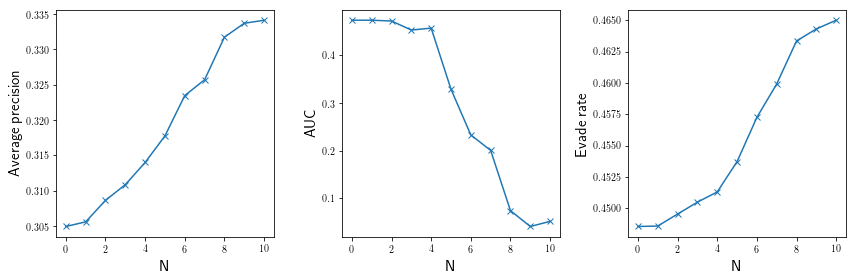

In [46]:
nfig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
x = np.arange(11)
y = np.mean(ap_mat, axis=(0, 2))
# e = np.std(ap_mat, axis=0)
ax.plot(x, y, marker='x')
# ax.errorbar(x, y, e, linestyle='None', capsize=2)
ax.set_ylabel('Average precision', fontsize=15)
ax.set_xlabel('N', fontsize=15)

ax = axes[1]
x = np.arange(11)
y = np.mean(auc_mat, axis=(0, 2))
# e = np.std(auc_mat, axis=0)
ax.plot(x, y, marker='x')
# ax.errorbar(x, y, e, linestyle='None', capsize=2)
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('N', fontsize=15)

ax = axes[2]
x = np.arange(11)
y = np.mean(er_mat, axis=(0, 2))
# e = np.std(er_mat, axis=0)
ax.plot(x, y, marker='x')
# ax.errorbar(x, y, e, linestyle='None', capsize=2)
ax.set_ylabel('Evade rate', fontsize=15)
ax.set_xlabel('N', fontsize=15)

nfig.tight_layout()

## Vary N given k

In [ ]:
knfig, axes = plt.subplots(1, 3, figsize=(12, 4))

k = 1
ax = axes[0]
x = np.arange(11)
y = ap_mat[k, :]
ax.plot(x, y, marker='x')
# ax.errorbar(x, y, e, linestyle='None', capsize=2)
ax.set_ylabel('Average precision', fontsize=15)
ax.set_xlabel('N', fontsize=15)

ax = axes[1]
x = np.arange(11)
y = auc_mat[k, :]
ax.plot(x, y, marker='x')
# ax.errorbar(x, y, e, linestyle='None', capsize=2)
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('N', fontsize=15)

ax = axes[2]
x = np.arange(11)
y = er_mat[k, :]
ax.plot(x, y, marker='x')
# ax.errorbar(x, y, e, linestyle='None', capsize=2)
ax.set_ylabel('Evade rate', fontsize=15)
ax.set_xlabel('N', fontsize=15)

knfig.tight_layout()

## Vary k

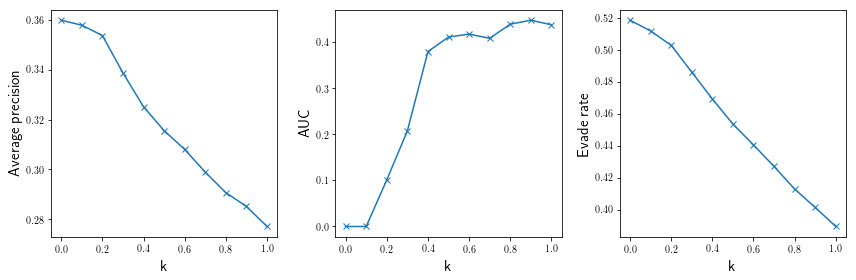

In [47]:
kfig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
x = np.arange(11)/10
y = np.mean(ap_mat, axis=(1, 2))
e = np.std(ap_mat, axis=1)
ax.plot(x, y, marker='x')
# ax.errorbar(x, y, e, linestyle='None', capsize=2)
ax.set_ylabel('Average precision', fontsize=15)
ax.set_xlabel('k', fontsize=15)

ax = axes[1]
x = np.arange(11)/10
y = np.mean(auc_mat, axis=(1, 2))
e = np.std(auc_mat, axis=1)
ax.plot(x, y, marker='x')
# ax.errorbar(x, y, e, linestyle='None', capsize=2)
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('k', fontsize=15)

ax = axes[2]
x = np.arange(11)/10
y = np.mean(er_mat, axis=(1, 2))
e = np.std(er_mat, axis=1)
ax.plot(x, y, marker='x')
# ax.errorbar(x, y, e, linestyle='None', capsize=2)
ax.set_ylabel('Evade rate', fontsize=15)
ax.set_xlabel('k', fontsize=15)

kfig.tight_layout()

In [ ]:
nfig.savefig('../rev2fig/%s-n.pdf' %data_name)
kfig.savefig('../rev2fig/%s-k.pdf' %data_name)
knfig.savefig('../rev2fig/%s-kn.pdf' %data_name)